<h1> Rapport du DataCamp </h1>

<h2> RAMP on qualitative and quantitative non-invasive monitoring of anti-cancer drugs </h2>

## DEMANOU WAMO Daniel


In [13]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

### Loading the data

In [14]:
data = pd.read_csv('train.csv')

y_df = data[['molecule', 'concentration']]
X_df = data.drop(['molecule', 'concentration'], axis=1)
spectra = X_df['spectra'].values                                        
spectra = np.array([np.array(dd[1:-1].split(',')).astype(float) for dd in spectra])    
X_df['spectra'] = spectra.tolist()

In [22]:
# Loading wavenumbers
freqs = pd.read_csv('freq.csv')
freqs = freqs['freqs'].values
print(freqs.shape, spectra.shape)

(1866,) (999, 1866)


In [17]:
# Types of molecules
np.unique(y_df['molecule'].values)

array(['A', 'B', 'Q', 'R'], dtype=object)

In [20]:
# Target for classification
molecule = y_df['molecule'].values
# Target for regression
concentration = y_df['concentration'].values
# "Raw" features
X = spectra

### travail effectué sur Feature extractor for classification¶

Durant ce challenge ma première action a été de me lancer dans le preprocessing de pour la classification mes premiers intuitions m'ont amené à partir sur du LabelEncoder pour mes variables catégorielles c'est-à-dire sur Vial et Solute. 

Mais je me suis rendu compte que cela n'avait presque pas d'influence sur l'erreur de classification. 
J'ai ensuite essayé de normaliser le spectral avec une norme L1 et par la suite avec une norme L2. 
j'ai pu observer que j'avais avec un randomforest une erreur de <strong>0.07</strong> avec L2 et de<strong> 0.085 </strong> avec une L1 soit une amélioration moyenne de <strong>0.03</strong> de mon erreur de classification.

J'ai donc pu tirer la conclusion que les feature Solute et vial n'avaient pas besoin d'un prepocessing  et qu'une simple normalisation de Spectral était suffisante pour la classification.

In [712]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import normalize

class FeatureExtractorClf(object):
    def __init__(self):
        #self.le = LabelEncoder()
        pass

    def fit(self, X_df, y_df):
        #for i in ['solute', 'vial'] :
        #X_df['solute'].values = self.le.fit(X_df['solute'].values, y_df['molecule'].values)
        #X_df['vial'].values = self.le.fit(X_df['vial'].values, y_df['molecule'].values)
        pass
    
    def transform(self, X_df):
        #for i in ['solute', 'vial'] :
        #X_df['vial'].values = self.le.transform(X_df['vial'].values)
        #X_df['solute'].values = self.le.transform(X_df['solute'].values)
        XX = np.array([np.array(dd) for dd in X_df['spectra']])
        XX = normalize(XX, norm='l2', axis=1, copy=True, return_norm=False)
        #for i in range(len(X_df['spectra'])):
            #X_df['spectra'][i] = XX[i]
        return XX

### travail effectué sur la Classification: 
En ce qui concerne la classification j'ai tout d'abort essayé les différents alogrorihtmes de la façon la plus naïve possibles ( c'est-à-dire sans jouer sur les paramètres) et j'ai regardé celui qui me donner la meilleure erreur sans cross validation, les résultats sont les suivants: 

<strong>RandomForestClassifier : 0.09 - 0.095 </strong>

<strong>GradientBoostingClassifier : 0.06 - 0.065 </strong>

<strong>Svm : 0.051 - 0.048</strong>

ces résultats m'ont conforté dans mon intuition qui était celle d'utiliser une Svm au vu du faible jeu de données que l'ont disposé pour faire le training.  

Je me suis ensuite dirigé vers des différentes méthodes de décomposition pour voir la plus efficace. une fois de plus j'ai utilisé les algorithmes de façon naïve sans chercher à les optimiser juste de manière à voir celle avec qui me donnerait la meilleure erreur pour une Svm les résultats en fonction des algorithmes sont les suivants:

<strong>PCA et SVM  : 0.051 </strong>

<strong>FastICA  et SVM :  0.19</strong>

<strong>NMF et SVM: 0.235</strong>

<strong>LatentDirichletAllocation et SVM : 0.53 </strong>

Au vu des résultats on peut bien conclure que le PCA est la méthode la plus adaptée pour la Svm dans ce cas.

Je suis donc partie sur un PCA que j'ai cross valider pour obtenir le nombre composant optimal. j'ai trouvé grâce à un GridSearchCV que n_components = 15 était le plus adapté.

DDans la suite j'ai cross valider le pipeline PCA et SVM pour obtenir les meilleurs paramètres de ma SVM pour cela j'ai utilisé gsearch.best_estimator_.named_steps qui me donne le meilleur paramètre parmi les imputs.

j'ai donc pus constater grâce aux cross validation qu'il n'était pas forcément intéressant ici de jouer sur énormément de paramètre mon meilleur score de train qui était de 0.02 d'erreur a été obtenue en cross valident uniquement sur pénalisation C. les autres paramètres par défaut de la Svm étaient déjà optimaux. 

le code suivant est un exemple de ceux que j'ai obtenu après mes cross validations.

In [715]:
from sklearn.ensemble import RandomForestClassifier ,GradientBoostingClassifier
from sklearn.decomposition import PCA, FastICA ,NMF, LatentDirichletAllocation   
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

class Classifier(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
    
        self.n_components = 13
        self.C = 1e6
        self.decision_function_shape = 'ovr'
        self.pca = PCA(n_components=self.n_components)
        self.svm = SVC(kernel='rbf', C=self.C, probability=True, decision_function_shape = self.decision_function_shape)
        #self.RandomForestClassifier = RandomForestClassifier()
        #self.GradientBoostingClassifier = GradientBoostingClassifier()
        #self.svm = SVC(probability=True)
        
        
        d = {"A":0, "B":1, "Q":2, "R":3}
        y=[d[k] for k in y]
        
        param = {
            
            #'pca__n_components':np.linspace(10, 20, 10).astype(int)
            'clf__C' : [1e5,1, 10],
            'clf__decision_function_shape': ['ovo', 'ovr', None]
            
        }
        

        #svm = SVC(kernel='rbf', C=1e6, probability=True)
        CLF = Pipeline(steps = [ ('pca', self.pca), ('clf', self.svm) ])
        
        gridsearch = GridSearchCV(estimator = CLF, param_grid = param, scoring='accuracy',n_jobs=1,iid=False, cv=9)
        gridsearch.fit(X, y)
        
        print(gridsearch.best_params_)
        
    
        self.dimension_reduction = gridsearch.best_estimator_.named_steps['pca']
        self.clf = gridsearch.best_estimator_.named_steps['clf']
        CLF.fit(X,y)
        
        self.pca = CLF.named_steps['pca']
        
        self.clf = CLF.named_steps['clf']
        
        X = self.pca.fit_transform(X)
        self.clf.fit(X, y)
                    


    def predict(self, X):
        
        X = self.pca.transform(X)
        
        y = self.clf.predict(X)
        
        return y_pred

    def predict_proba(self, X):
        
        X = self.pca.transform(X)
        
        y_pred = self.clf.predict_proba(X)
        
        return y_pred

In [716]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

labels = np.array(['A', 'B', 'Q', 'R'])

def train_test_model_clf(X_df, y_df, skf_is, FeatureExtractor, Classifier):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()
    y_train_clf = y_train_df['molecule'].values

    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy() 
    y_test_clf = y_test_df['molecule'].values 
    # Feature extraction
    fe_clf = FeatureExtractor()
    
    fe_clf.fit(X_train_df, y_train_df)
    X_train_array_clf = fe_clf.transform(X_train_df)
    X_test_array_clf = fe_clf.transform(X_test_df)
    # Train
    clf = Classifier()
    #print(y_train_clf.shape)
    clf.fit(X_train_array_clf, y_train_clf)
    # Test 
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = %s' % error)                                                                            
    print('classification report:\n %s' % classification_report(y_test_clf, y_pred_clf))
    print('confusion matrix:\n %s' % confusion_matrix(y_test_clf, y_pred_clf))


skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57)  
skf_is = list(skf.split(X_df))[0]

train_test_model_clf(X_df, y_df, skf_is, FeatureExtractorClf, Classifier)

{'clf__decision_function_shape': 'ovr', 'clf__C': 100000.0}
error = 0.02
classification report:
              precision    recall  f1-score   support

          A       0.98      0.97      0.98        63
          B       0.96      0.96      0.96        45
          Q       1.00      1.00      1.00        40
          R       0.98      1.00      0.99        52

avg / total       0.98      0.98      0.98       200

confusion matrix:
 [[61  2  0  0]
 [ 1 43  0  1]
 [ 0  0 40  0]
 [ 0  0  0 52]]


##  travail sur Feature extractor for regression
En ce qui concerne le preprocessing de mes Datas pour la régression, j'ai réessayé ce que j'avais déjà fait pour la classification et j'ai retrouvé la même conclusion qu'il faut uniquement jouer sur les spectra et le normaliser.

In [745]:
labels = np.array(['A', 'B', 'Q', 'R'])

class FeatureExtractorReg(object):
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):                                                   
        XX = np.array([np.array(dd) for dd in X_df['spectra']])                  
        #XX -= np.median(XX, axis=1)[:, None]                                     
        #XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]                          
        #XX = np.concatenate([XX, X_df[labels].values], axis=1) 
        #XX = normalize(XX, norm='l2', axis=1, copy=True, return_norm=False)``
        #XX = np.array([np.array(dd) for dd in X_df['spectra']])
        XX -= np.median(XX, axis=1)[:, None]
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]
        spectra_mean = np.mean(XX, axis=1).reshape(len(X_df), 1)
        spectra_min = np.amin(XX[:, :900], axis=1).reshape(len(X_df), 1)
        spectra_minmax = np.amax(XX[:, :900], axis=1).reshape(len(X_df), 1)
        spectra_max = np.amax(XX[:, -900:], axis=1).reshape(len(X_df), 1)
        spectra_maxmin = np.amin(XX[:, -900:], axis=1).reshape(len(X_df), 1)
        XX = np.concatenate(
            [XX, spectra_mean, spectra_min, spectra_minmax, spectra_max, spectra_maxmin, X_df[labels].values],
            axis=1
        )
        return XX   

## travail effectué sur la régression


Pour la régression j'ai d'abord essayé comme pour la classification plusieurs algorithmes et j'ai obtenu les résultats suivants en fonction des algorithmes.

<strong> GradientBoostingRegressor : mare = O.23 </strong>

<strong>MLPRegressor : mare =  0.681830397615  Méthode de deep learning de sklearn</strong>

<strong>BaggingRegressor  : mare = 0.30</strong>

<strong>LinearRegression : mare = 0.27</strong>

<strong>PLSRegression : mare = 0.58</strong>

<strong>SVR : 0.27</strong>

suite à ces résultats je suis donc parie sur un GradientBoostingRegressor mais avant de cross valider ces paramètres j'ai décidé de tester plusieurs techniques de redimentionement des données. 
j'ai eu les résultats suivants : 

<strong>PCA et GradientBoostingRegressor : mare = 0.23 </strong>

<strong>FastICA et GradientBoostingRegressor : mare = 0.58 </strong>

<strong>NMF et GradientBoostingRegressor : mare = 0.40 </strong>

<strong>LatentDirichletAllocation  et GradientBoostingRegressor : mare = 0.86</strong>

<strong>Isomap et GradientBoostingRegressor : mare = 0.46 </strong>

<strong>TSNE et GradientBoostingRegressor : mare = 0.81 </strong>

une fois de plus je suis venu à la conclusion que PCA semble être le meilleur algorithme pour enlever la redondance d'informations dans ce cas.

Ensuite j'ai effectué un GridSearchCV pour déterminer les meilleurs paramètres pour mon PCA à savoir ici : 

<strong>n_components = 13 </strong>

j'ai ensuite effectué GridSearchCV sur mon GradientBoostingRegressor pour obtenir les meilleures performances en fonction des molécules. 

<strong>molécule 'A' : learning_rate=0.1 , alpha = 0.4, n_estimators = 300</strong>

<strong>molécule 'B': learning_rate=0.077499999, alpha = 0.2, n_estimators =300</strong>

<strong>molécule 'Q': learning_rate=0.077499999, alpha=0.4, n_estimators =200</strong>

<strong>molécule 'R'learning_rate=0.1, alpha = 0.4, n_estimators =300</strong>

<strong>ceci m'a permis d'obtenir  mare =  0.156268869643 en train.</strong>

ce résultat n'étant pas satisfaisant j'ai decider de trouver un régresseur optimal pour chaque molécule mais une fois de plus je me suis rendu compte que GradientBoostingRegressor avait le meilleur résultat pour chacun d'entre eux mais cette expérience m'a permis de comprendre que certaines molécules notamment A et Q apprenaient moins bien que les autres j'ai donc décidé de faire des réseaux neurone sur ces deux molécule mais les résultats sont moins bons qu'avec un GradientBoostingRegressor.

## quelques courbes pour appuyer le choix de mon algorithme :


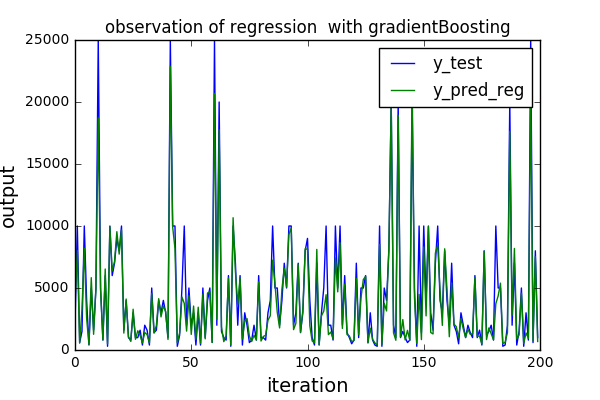

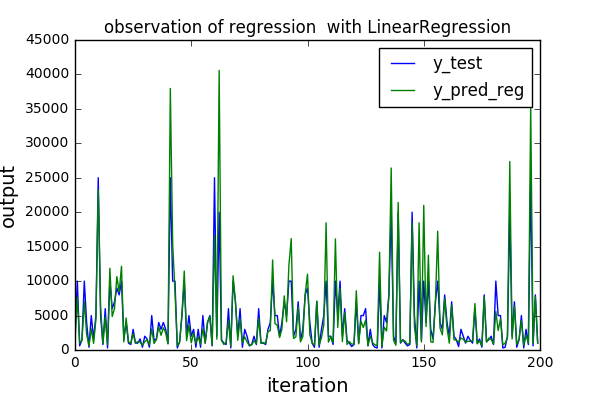

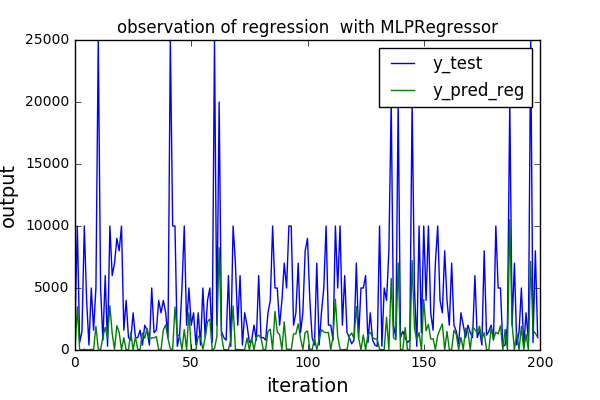

In [706]:
from IPython.display import Image, display
Image(filename='regresion with gradient boosting.png') 

listOfImageNames = ['regresion with gradient boosting.png',
                    'regresion with LinearRegression.png','regresion with MLPRegressor.png']

for imageName in listOfImageNames:
    display(Image(filename=imageName))

###### On voit bien sur ces courbes que GradientBoostingRegressor régresse mieux que les autres. on voit aussi que MLPRegressor régresse très mal

#### Le code suivant est ce qui permet de tester les algos de façon naïve pour la regression et ce qui permet aussi de faire les cross Validations 

In [755]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.svm import SVC
 
class Regressor(BaseEstimator):
    def __init__(self):
        pass
 
    def fit(self, X, y):
        self.n_components = 10
        self.C = 100300
        self.list_molecule = ['A', 'B', 'Q', 'R']
        self.dict_reg = {}
        for mol in self.list_molecule:
            self.dict_reg[mol] = Pipeline([
                ('pca', PCA(n_components=self.n_components)),
                ('reg', SVC(C=self.C, kernel='poly', degree=3, gamma=1, coef0=2, probability=True))
            ])
            
        for i, mol in enumerate(self.list_molecule):
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]
            XX_mol = X[ind_mol]
            y_mol = y[ind_mol].astype(float)
            self.dict_reg[mol].fit(XX_mol, y_mol)
 
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i, mol in enumerate(self.list_molecule):
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]
            XX_mol = X[ind_mol].astype(float)
            y_pred[ind_mol] = self.dict_reg[mol].predict(XX_mol)
        return y_pred

{'clf__decision_function_shape': 'ovo', 'clf__C': 100000.0}
error =  0.025


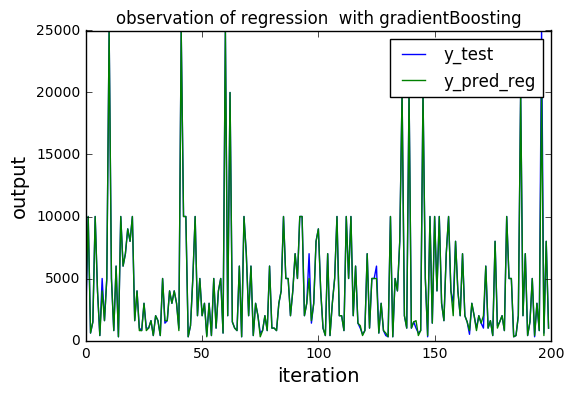

mare =  0.0406071428571
combined error =  0.0302023809524


In [756]:
def mare_score(y_true, y_pred):                                                  
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()                                  
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy()                                    
    y_train_clf = y_train_df['molecule'].values                              
    y_train_reg = y_train_df['concentration'].values                         
    y_test_clf = y_test_df['molecule'].values                                
    y_test_reg = y_test_df['concentration'].values                           

    # Classification
    fe_clf = FeatureExtractorClf()                     
    fe_clf.fit(X_train_df, y_train_df)                                       
    X_train_array_clf = fe_clf.transform(X_train_df)                         
    X_test_array_clf = fe_clf.transform(X_test_df)                           
                                                                                 
    clf = Classifier()                                            
    clf.fit(X_train_array_clf, y_train_clf)                                  
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = ', error)
    
    # Regression
    fe_reg = FeatureExtractorReg()                     
    for i, label in enumerate(labels):
        # For training, we use 
        X_train_df.loc[:, label] = (y_train_df['molecule'] == label)         
        X_test_df.loc[:, label] = y_proba_clf[:, i]                          
    fe_reg.fit(X_train_df, y_train_reg)                                      
    X_train_array_reg = fe_reg.transform(X_train_df)                         
    X_test_array_reg = fe_reg.transform(X_test_df)                           
                                                                                 
    reg = Regressor()                                              
    reg.fit(X_train_array_reg, y_train_reg)                               
    y_pred_reg = reg.predict(X_test_array_reg)
    iteration = range(len(y_test_reg))
    plt.plot(iteration,y_test_reg,label="y_test")
    plt.plot(iteration,y_pred_reg,label="y_pred_reg" )
    plt.title("observation of regression  with gradientBoosting")
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("output", fontsize=14)
    plt.legend()
    plt.savefig('regresion with gradient boosting.png')
    plt.show()
    
    mare = mare_score(y_test_reg, y_pred_reg)
    print('mare = ', mare)                
    print('combined error = ', 2. / 3 * error + 1. / 3 * mare)


skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

To run user_test_submission.py and test your code from the notebook you can do:

In [757]:
!python user_test_submission.py

/Users/DEMANOU/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/DEMANOU/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Reading file ...
Training file ...
--------------------------
error = 0.02
mare =  0.0395238095238
combined error =  0.0265079365079
--------------------------
error = 0.065
mare =  0.0693948412698
combined error =  0.0664649470899
